In [1]:
import sys
import os
import shutil
import pathlib
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline
from Bio import SeqIO
import pandas as pd
from qiime2 import Artifact, Metadata
from qiime2.plugins.feature_table.methods import filter_seqs, filter_features
from qiime2.plugins.feature_table.visualizers import tabulate_seqs


def extract_fasta(file, dest):
    with tempfile.TemporaryDirectory() as temp:
        file.export_data(temp)
        temp_pathlib = pathlib.Path(temp)
        for file in temp_pathlib.iterdir():
            if file.suffix == '.fasta':
                shutil.copy(file, dest) 

In [2]:
# Loading unfiltered rep-seqs and table (output from dada2) as qiime2 artifacts 
table = Artifact.load('feature_table.qza')
rep_seqs = Artifact.load('rep_seqs.qza')

In [3]:
# Viewing the rep-seqs, we can see that we have a number of sequences that are likely too short 
# for accurate taxonomic assignment 
rep_seqs_tab = tabulate_seqs(rep_seqs)
rep_seqs_tab.visualization

<visualization: Visualization uuid: 7b03e0b5-5a21-4b21-992d-1d21209d2f32>

In [4]:
# Length filtering of rep_seqs

# Pull fasta from rep_seqs to use as metadata
os.makedirs('fastas', exist_ok=True)
extract_fasta(rep_seqs, 'fastas')

# Parse fasta to get IDs and lengths, then send to pandas dataframe 
with open('fastas/dna-sequences.fasta') as fasta_file:
    featureids = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        featureids.append(seq_record.id)
        lengths.append(len(seq_record.seq))

rep_seqs_meta = pd.DataFrame({"FeatureID":featureids, "Length":lengths})


# Selecting only the features which have sequence lengths below a specified value (120 in this instance)
# Then sending them to a CSV which will make up our exclusion metadata
features_to_exclude = rep_seqs_meta[rep_seqs_meta['Length'] < 120]

features_to_exclude['FeatureID'].to_csv('Features-to-exclude.csv', index=False)

exclude = Metadata.load("Features-to-exclude.csv")

# Filter rep-seqs based on seqs_to_exclude
rep_seqs_filt = filter_seqs(rep_seqs, 
                           metadata = exclude,
                           exclude_ids = True)

# Filter table based on seqs_to_exclude
table_filt = filter_features(table,
                            metadata = exclude,
                            exclude_ids = True)

In [5]:
# Retabulating the rep-seqs we can see that all features with a representative sequence length 
# less than our specified value (120) is now removed!
rep_seqs_filt_tabulated = tabulate_seqs(rep_seqs_filt.filtered_data)
rep_seqs_filt_tabulated.visualization

<visualization: Visualization uuid: 0761d540-a01f-4806-a6fd-94b263def318>

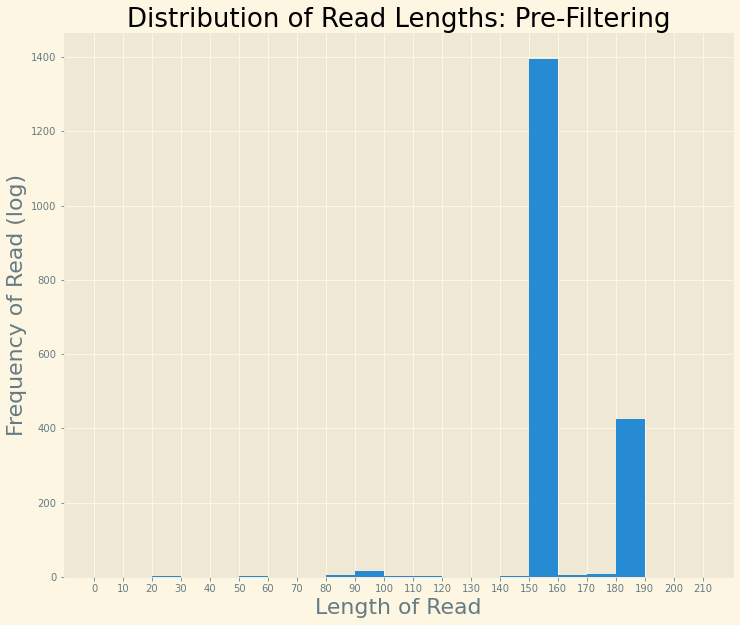

In [7]:
# Pre-filtering graph
df = rep_seqs_meta
plt.style.use('Solarize_Light2')
plt.figure(figsize = (12,10))
bin_list=(range(0,220,10))
plt.hist(df['Length'],bins=bin_list)
plt.xlabel('Length of Read', size = 22)
plt.xticks(bin_list)
plt.ylabel('Frequency of Read (log)', size = 22)
plt.title('Distribution of Read Lengths: Pre-Filtering', size = 26, color='black')
#plt.savefig('../../images/pre_filter_length.png')
plt.show()

In [8]:
# Getting post-filter dataframe 
os.system('mkdir temp')
extract_fasta(rep_seqs_filt.filtered_data, 'temp')

# Parse fasta to get IDs and lengths, then send to pandas dataframe 
with open('temp/dna-sequences.fasta') as fasta_file:
    featureids = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        featureids.append(seq_record.id)
        lengths.append(len(seq_record.seq))

rep_seqs_meta_post = pd.DataFrame({"FeatureID":featureids, "Length":lengths})
shutil.rmtree('fastas')
shutil.rmtree('temp')

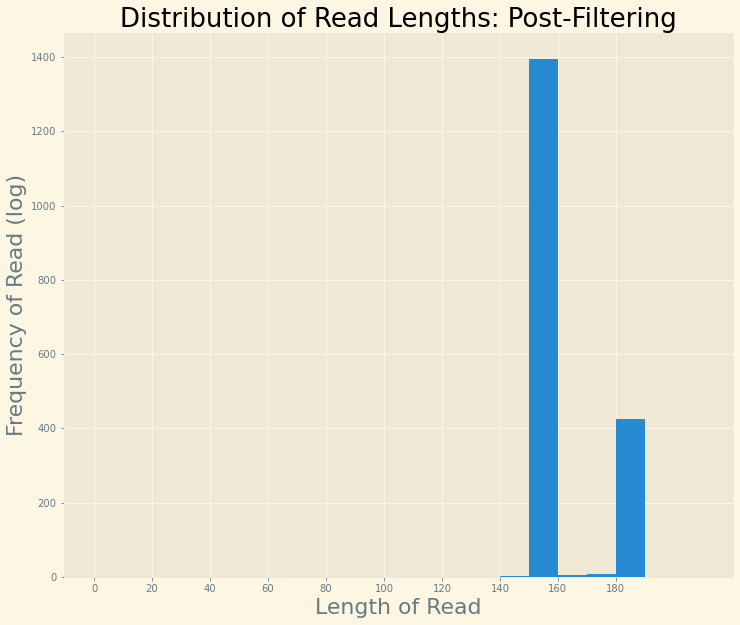

In [11]:
# Post-filtering graph
df2 = rep_seqs_meta_post
plt.style.use('Solarize_Light2')
plt.figure(figsize = (12,10))
bin_list=(range(0,220,10))
plt.hist(df2['Length'], bin_list)
plt.xlabel('Length of Read', size = 22)
plt.xticks(range(0,200,20))
plt.ylabel('Frequency of Read (log)', size = 22)
plt.title('Distribution of Read Lengths: Post-Filtering', size = 26, color='black')
#plt.savefig('../../images/post_filter_length.png')
plt.show()